# 1. Libraries Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import BaseEstimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import hamming_loss, roc_auc_score, confusion_matrix, roc_curve, f1_score, balanced_accuracy_score, matthews_corrcoef

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from time import time
from copy import deepcopy

In [2]:
import sys
sys.executable

'/usr/local/opt/python@3.11/bin/python3.11'

## 2. Class for sampling based classifier

In [3]:
class SamplingClassifier(BaseEstimator):
    def __init__(self, est = LogisticRegression(), samp = None):
        self.est_ = deepcopy(est)
        self.samp_ = samp
        
    def fit(self, X, y):
        if self.samp_ is None:
            X_res, y_res = X, y
        else:
            X_res, y_res = self.samp_.fit_resample(X, y)
        self.est_.fit(X_res, y_res)
        
    def predict(self, X):
        return self.est_.predict(X)

## 3. Setting up DES Models  
Dynamic Ensemble Selection methods

In [4]:
from deslib.dcs.a_priori import APriori
from deslib.dcs.mcb import MCB  
from deslib.dcs.ola import OLA  
from deslib.des.des_p import DESP           
from deslib.des.knora_e import KNORAE       
from deslib.des.knora_u import KNORAU       
from deslib.des.meta_des import METADES     
from deslib.static import StackedClassifier, Oracle

In [5]:
#deslib has the use of deprecated np.int and np.float. Set the types manually.
np.int = int
np.float = float

In [6]:
class DES(BaseEstimator):
    def __init__(self, pool = RandomForestClassifier(n_estimators = 100, max_features = 'auto', random_state = 1), model = KNORAE):
        self.pool = pool
        self.model = model
        self.est = None
        
    def fit(self, X, y, dsel_size = 0.5):
        X_train, X_dsel, y_train, y_dsel = train_test_split(X, y, test_size = dsel_size,random_state = 101)
        self.pool.fit(X_train, y_train)
        self.est = self.model(pool_classifiers = self.pool, random_state = 101).fit(X_dsel, y_dsel)
        
    def predict(self,X):
        return self.est.predict(X) 

## 4. Helper functions

In [49]:
def is_pareto_efficient(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

In [50]:
def pareto_ranking(data, labels):
    '''
    Pareto ranking the pandas dataframe by selected variables
    : param data : A pandas dataframe
    : param labels : A list of columns to rank
    % return: the same dataframe with additinal column 'pareto_rank' 
    '''
    matrix = data[labels].values # Матрица пары значений FNR-FPR
    idx_ = np.array([i for i in data.index])
    pareto_sets = []
    idx_sets = []
    pareto_set_found = True
    while pareto_set_found:
        pareto_set_found = False
        pareto_set = is_pareto_efficient(matrix)
        if len(matrix[pareto_set] > 0):
            pareto_sets.append(matrix[pareto_set])
            idx_sets.append(idx_[pareto_set])
            matrix = matrix[np.invert(pareto_set)]
            idx_ = idx_[np.invert(pareto_set)]
            pareto_set_found = True
    
    data['pareto_rank'] = np.empty(data.shape[0])
    for p_rank, idx in enumerate(idx_sets):
        for i in idx:
            data.at[i,'pareto_rank'] = p_rank + 1 
    
    return data

def pareto_plot(df, var):
    plt.scatter(df[var[0]], df[var[1]], c = 'b')
    plt.scatter(df[df.pareto_rank == 1][var[0]], df[df.pareto_rank == 1][var[1]], c = 'r')
    plt.xlabel(var[0])
    plt.ylabel(var[1])

In [51]:
def crowding_distance(data, labels):
    matrix = data[labels]
    matrix['dist'] = np.zeros(data.shape[0])
    for l in labels:
        matrix.sort_values(by = l, inplace = True)
        matrix.dist = matrix.dist + (matrix.shift(periods = -1)[l] - matrix.shift(periods = 1)[l])/(matrix[l].max() - matrix[l].min())

    for l in labels:
        matrix.at[np.argmin(matrix[l]), 'dist'] = np.inf
        matrix.at[np.argmax(matrix[l]), 'dist'] = np.inf
    
    new_data = deepcopy(data)
    new_data['distance'] = matrix.dist
    return new_data

In [52]:
def cross_val_predict(est, X, y, cv = 4):
    start = time()
    pred = np.empty(X.shape[0])
    #print('Start of the KFold. [%.1f s]' %(time() - start))
    kf = KFold(n_splits = cv, shuffle = True, random_state = 101)
    for train_index, test_index in kf.split(X, y):
        #print('Another Split. [%.1f s]' %(time() - start))
        est.fit(X[train_index], y[train_index])
        pred[test_index] = est.predict(X[test_index])
    return pred

In [53]:
def test_models(models, X, y, C_FP = 1, C_FN = 5, k = 2, cv  = 4, verbose = True):
    '''
    Cross val testing of set of models defined by dict {'model_name' : model}
    Returns the dict  {'model' : [], 'f1' : [], 'bacc' : [], 'FPR' : [], 'FNR' : [], 'Costs' : []}
    '''
    scores = {'model' : [], 'F1' : [], 'G_mean' : [], 'AUC' : [], 'FPR' : [], 'FNR' : [], 'Gen_mean' : [], 'Costs' : [], 'MCC' : []}
    #big_start = time()
    #print('Start of the cycle. [%.1f s]' %(time() - big_start))
    for m in models:
        #print('Start of another model. [%.1f s]' %(time() - big_start))
        start = time()
        
        #print('Start of the prediction. [%.1f s]' %(time() - start))
        y_pred = cross_val_predict(models[m], X, y, cv = cv)
        
        #print('Start of the confusion matrix.[%.1f s]' %(time() - start))
        cm = confusion_matrix(y, y_pred)
        scores['model'].append(m)
        scores['F1'].append(f1_score(y, y_pred))
        scores['FPR'].append(cm[0,1] / (cm[0,0] + cm[0,1]))
        scores['FNR'].append(cm[1,0] / (cm[1,0] + cm[1,1]))
        scores['G_mean'].append((cm[0,0] / (cm[0,0] + cm[0,1]) * cm[1,1] / (cm[1,0] + cm[1,1])) ** 0.5)
        scores['AUC'].append(roc_auc_score(y, y_pred))
        scores['Gen_mean'].append((((cm[0,0] / (cm[0,0] + cm[0,1]))**k + (cm[1,1] / (cm[1,0] + cm[1,1]))**k) / 2) ** (1/k))
        scores['Costs'].append(cm[1,0]*C_FN / (cm[1,0] + cm[1,1]) + cm[0,1] * C_FP / (cm[0,0] + cm[0,1]))
        scores['MCC'].append(matthews_corrcoef(y, y_pred))
        
        if verbose:
            print('%10s: F1 = %.3f G_mean = %.3f AUC = %.3f FPR = %.3f FNR = %.3f Costs = %.3f Gen_mean = %.3f MCC = %.3f [%.1f s]' 
                  %(m, scores['F1'][-1],  scores['G_mean'][-1], scores['AUC'][-1], 
                    scores['FPR'][-1], scores['FNR'][-1], scores['Costs'][-1], scores['Gen_mean'][-1], scores['MCC'][-1], time() - start))
    return pd.DataFrame(scores)

## 5. Data Loading and Feature Engineering

In [54]:
id_df = pd.read_csv('./data/identity.csv')
tr_df = pd.read_csv('./data/transaction.csv')

In [55]:
id_df.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [56]:
tr_df.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
print(f'Transaction dataset has {tr_df.shape[0]} rows and {tr_df.shape[1]} columns.')

Transaction dataset has 590540 rows and 394 columns.


In [58]:
# Let's combine two datasets
df = pd.merge(tr_df, id_df, on='TransactionID', how='left')

In [59]:
print(f'Test dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

Test dataset has 590540 rows and 434 columns.


In [60]:
one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
many_null_cols = [col for col in df.columns if df[col].isnull().sum() / df.shape[0] > 0.9]
big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
cols_to_drop = list(set(many_null_cols + big_top_value_cols + one_value_cols))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

66

In [61]:
df = df.drop(cols_to_drop, axis=1)

In [62]:
df.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
                   ...   
id_36              object
id_37              object
id_38              object
DeviceType         object
DeviceInfo         object
Length: 368, dtype: object

In [63]:
str_columns = df.select_dtypes(include='object').columns.tolist()

In [64]:
for col in str_columns:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

In [65]:
df.shape

(590540, 368)

In [66]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id']

In [242]:
%%time
len(useful_features)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 17.9 µs


288

### 5.1 Sampling

In [67]:
df_saved = df

In [68]:
df = df_saved

In [69]:
# Calculate the distribution of the target column
target_distribution = df['isFraud'].value_counts(normalize=True)

# Set the random seed for reproducibility
random_seed = 42

# Sample the dataframe based on the target column distribution
df_subset = df.groupby('isFraud', group_keys=False).apply(lambda x: x.sample(frac=min(len(x)/len(df), 0.05), random_state=random_seed))

# Reset the index of the subset dataframe
df_subset.reset_index(drop=True, inplace=True)

In [70]:
print(df_subset.shape)
print(df.shape)

(29217, 368)
(590540, 368)


In [71]:
df = df_subset

### 5.2 Handling NaN

In [72]:
df = df.fillna(df.mean())

In [73]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = df.drop('isFraud', axis=1).values
X = scaler.fit_transform(X)
y = df['isFraud'].values

In [74]:
len(X)

29217

In [75]:
len(y)

29217

## Testing Models

In [44]:
clf =   {'GB'     : GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 100, random_state = 101),
         'AB'     : AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1),
                                       learning_rate = 0.5, n_estimators = 100, random_state = 101),
         'BR'     : BaggingClassifier(max_features = 0.9, max_samples = 0.66, n_estimators = 100, random_state = 101),
         'LR'     : LogisticRegression(class_weight = 'balanced'),
         'RF'     : RandomForestClassifier(max_features = 'auto', n_estimators = 100, bootstrap = True, 
                                           class_weight = 'balanced_subsample', random_state = 101),
         'ET'     : ExtraTreesClassifier(max_features = 'auto', n_estimators = 100, bootstrap = True, 
                                         class_weight = 'balanced_subsample', random_state = 101),
      }

sampl = { 'None'   : None,
          'SMOTE'  : SMOTE(random_state = 101),
          'ADASYN' : ADASYN(random_state=101),
          'RUS'    : RandomUnderSampler(random_state = 101)
        }

des = {   'APriori'  : APriori(),
          'MCB'      : MCB(),
          'OLA'      : OLA(), 
          'DESP'     : DESP(), 
          'KNORAE'   : KNORAE(), 
          'U-KNORAU' : KNORAU(), 
          'E-METADES ' : METADES() 
          }

In [45]:
# Create pool of candidate models
models = {}

for s in sampl:
    for c in clf:
        models['S:' + s[0] + ':' + c[0]] = SamplingClassifier(est = clf[c], samp = sampl[s])

for s in sampl:
    for d in des:
        models['D:' + s[0] + ':' + d[0]] = SamplingClassifier(est = des[d], samp = sampl[s])

len(models)

52

In [238]:
cv = 3

scores = test_models(models, X, y, C_FP = 1, C_FN = 5, k = 2, cv  = cv, verbose = True)

KeyboardInterrupt: 

In [223]:
scores_3cv_full = scores

In [224]:
scores_3cv_full.to_csv('scores_3cv_5p.csv')

## Retrive scores

In [83]:
scores = pd.read_csv('scores_3cv_5p.csv')

In [84]:
scores.dtypes

Unnamed: 0      int64
model          object
F1            float64
G_mean        float64
AUC           float64
FPR           float64
FNR           float64
Gen_mean      float64
Costs         float64
MCC           float64
dtype: object

In [85]:
scores = scores.drop('Unnamed: 0', axis=1)

In [86]:
scores.head(5)

,model,F1,G_mean,AUC,FPR,FNR,Gen_mean,Costs,MCC
0,S:N:G,0.358,0.520,0.633,6.317e-03,0.728,0.729,3.644,0.366
1,S:N:A,0.324,0.452,0.602,1.509e-03,0.795,0.721,3.978,0.392
2,S:N:B,0.352,0.473,0.611,1.228e-03,0.776,0.724,3.881,0.423
3,S:N:L,0.146,0.730,0.735,1.865e-01,0.344,0.739,1.908,0.183
4,S:N:R,0.240,0.372,0.569,3.510e-04,0.862,0.714,4.309,0.350


In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision = 3, suppress = True)
pd.set_option('display.precision', 3)

import warnings
warnings.filterwarnings("ignore")

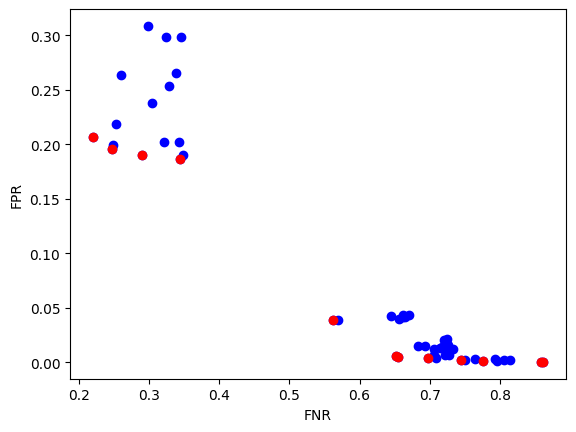

In [90]:
var = ['FNR', 'FPR']
scores = pareto_ranking(scores, var)
pareto_plot(scores, var)

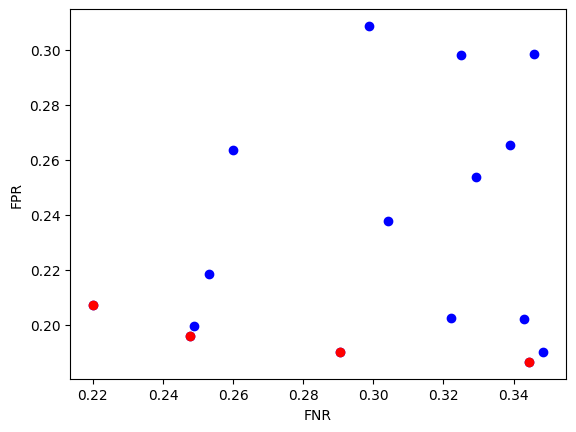

In [91]:
threshold = 0.4
lens = scores[scores.FNR < threshold][scores.FPR < threshold]
pareto_plot(lens, var)

In [92]:
for r in scores['pareto_rank'].unique():
    print('Rank %1d (%2d models) average cost is %5.1f' %(r, scores[scores['pareto_rank'] == r].Costs.count(),
                                                             scores[scores['pareto_rank'] == r].Costs.mean()))

Rank 3 (13 models) average cost is   3.2
Rank 2 ( 8 models) average cost is   3.1
Rank 1 (12 models) average cost is   2.9
Rank 4 ( 5 models) average cost is   2.8
Rank 6 ( 5 models) average cost is   3.3
Rank 7 ( 2 models) average cost is   2.8
Rank 5 ( 7 models) average cost is   2.8


## Final Ensamble

In [93]:
class SimpleVoting(BaseEstimator):
    def __init__(self, models):
        self.estimators_ = models
    
    def fit(self, X, y, cv = 4):
        for e in self.estimators_:
            e.fit(X, y)
    
    def predict_proba(self, X):
        pred_matrix = np.empty((X.shape[0], len(self.estimators_)))
        for i, e in enumerate(self.estimators_):
            pred_matrix[:,i] = e.predict(X)
        return pred_matrix.mean(axis = 1)
    
    def predict(self, X, threshold = 0.5):
        return np.array([0 if i < threshold else 1 for i in self.predict_proba(X)])

In [96]:
opt_model_set = []
for m in lens[lens['pareto_rank'] == 1].model.values:
    opt_model_set.append(models[m])
print(len(opt_model_set))
    
ext_model_set = []
for m in scores[scores['pareto_rank'] == 1].model.values:
    ext_model_set.append(models[m])
print(len(ext_model_set))

full_model_set = []
for m in scores.model.values:
    full_model_set.append(models[m])
print(len(full_model_set))

4
12
52


3


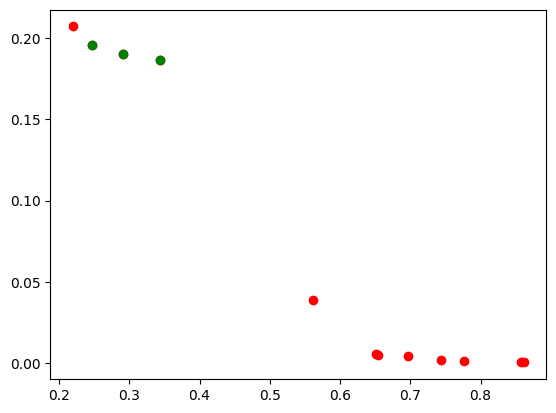

In [98]:
dist_thresh = 0
threshold = 0.4
th_scores = scores[scores.FNR < threshold][scores.FPR < threshold]
new_scores = crowding_distance(th_scores[th_scores['pareto_rank'] == 1], var)

dist_model_set = []
for m in new_scores[new_scores.distance > dist_thresh].model.values:
    dist_model_set.append(models[m])
print(len(dist_model_set))
plt.scatter(scores[scores['pareto_rank'] == 1].FNR, scores[scores['pareto_rank'] == 1].FPR, c ='r')
plt.scatter(new_scores[new_scores.distance > dist_thresh].FNR, new_scores[new_scores.distance > dist_thresh].FPR, c ='g')             

In [95]:
new_models = {'sv_opt'  : SimpleVoting(opt_model_set),
              #'sv_dist' : SimpleVoting(dist_model_set)
             }
cv = 3
print('%10s: F1 = %.3f G_mean = %.3f AUC = %.3f FPR = %.3f FNR = %.3f Costs = %.3f Gen_mean = %.3f MCC = %.3f' 
      %('best est', scores.F1.max(), scores.G_mean.max(), scores.AUC.max(),  scores.FPR.min(),  
        scores.FNR.min(), scores.Costs.min(), scores.Gen_mean.max(), scores.MCC.max()))

scores_np = test_models(new_models, X, y, cv  = cv, verbose = True)

  best est: F1 = 0.447 G_mean = 0.786 AUC = 0.787 FPR = 0.000 FNR = 0.220 Costs = 1.307 Gen_mean = 0.787 MCC = 0.458
    sv_opt: F1 = 0.150 G_mean = 0.783 AUC = 0.783 FPR = 0.222 FNR = 0.213 Costs = 1.287 Gen_mean = 0.783 MCC = 0.207 [40.3 s]


In [97]:
new_models = {'sv_dist' : SimpleVoting(dist_model_set)
             }
cv = 3
print('%10s: F1 = %.3f G_mean = %.3f AUC = %.3f FPR = %.3f FNR = %.3f Costs = %.3f Gen_mean = %.3f MCC = %.3f' 
      %('best est', scores.F1.max(), scores.G_mean.max(), scores.AUC.max(),  scores.FPR.min(),  
        scores.FNR.min(), scores.Costs.min(), scores.Gen_mean.max(), scores.MCC.max()))

scores_np = test_models(new_models, X, y, cv  = cv, verbose = True)

  best est: F1 = 0.447 G_mean = 0.786 AUC = 0.787 FPR = 0.000 FNR = 0.220 Costs = 1.307 Gen_mean = 0.787 MCC = 0.458
    sv_ext: F1 = 0.169 G_mean = 0.777 AUC = 0.778 FPR = 0.175 FNR = 0.268 Costs = 1.517 Gen_mean = 0.780 MCC = 0.221 [8.6 s]


In [101]:
new_models = {'sv_ext' : SimpleVoting(ext_model_set)
             }
cv = 3
print('%10s: F1 = %.3f G_mean = %.3f AUC = %.3f FPR = %.3f FNR = %.3f Costs = %.3f Gen_mean = %.3f MCC = %.3f' 
      %('best est', scores.F1.max(), scores.G_mean.max(), scores.AUC.max(),  scores.FPR.min(),  
        scores.FNR.min(), scores.Costs.min(), scores.Gen_mean.max(), scores.MCC.max()))

scores_np = test_models(new_models, X, y, cv  = cv, verbose = True)

  best est: F1 = 0.447 G_mean = 0.786 AUC = 0.787 FPR = 0.000 FNR = 0.220 Costs = 1.307 Gen_mean = 0.787 MCC = 0.458
    sv_ext: F1 = 0.464 G_mean = 0.616 AUC = 0.688 FPR = 0.007 FNR = 0.618 Costs = 3.098 Gen_mean = 0.752 MCC = 0.465 [2090.4 s]


In [100]:
scores[scores.FNR < 0.4][scores.FPR < 0.4][scores['pareto_rank'] == 1]

,model,F1,G_mean,AUC,FPR,FNR,Gen_mean,Costs,MCC,pareto_rank
3,S:N:L,0.146,0.730,0.735,0.186,0.344,0.739,1.908,0.183,1.0
19,S:R:A,0.154,0.758,0.760,0.190,0.290,0.761,1.642,0.201,1.0
20,S:R:B,0.157,0.786,0.787,0.207,0.220,0.787,1.307,0.214,1.0
22,S:R:R,0.159,0.778,0.778,0.196,0.248,0.779,1.434,0.212,1.0
